In [0]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import cmath
import math
import time

In [0]:
# # Fixed Parameters
# S0 = 100
# K = 80
# k = np.log(K)
# r = 0.1
# q = 0.0

# T = 0.1;


In [0]:
def generic_CF(u, params, S0, K, r, q, T, model, ifrelative):
    
    if (model == 'GBM'):
        
        sig = params[0]
        mu = np.log(S0) + (r-q-sig**2/2)*T
        a = sig*np.sqrt(T)
        phi = np.exp(1j*mu*u-(a*u)**2/2)
        
    elif(model == 'Heston'):
        
        kappa  = params[0]
        theta  = params[1]
        sigma  = params[2]
        rho    = params[3]
        v0     = params[4]
        
        tmp = (kappa-1j*rho*sigma*u)
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2)
        
        pow1 = 2*kappa*theta/(sigma**2)
        
        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2))
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp)
        log_phi = numer1 - log_denum1 - tmp2
        phi = np.exp(log_phi)
        
        #g = np.sqrt((kappa-1j*rho*sigma*u)**2+(u*u+1j*u)*sigma*sigma)
        #beta = kappa-rho*sigma*1j*u
        #tmp = g*T/2
        
        #temp1 = 1j*(np.log(S0)+(r-q)*T)*u + kappa*theta*T*beta/(sigma*sigma)
        #temp2 = -(u*u+1j*u)*v0/(g/np.tanh(tmp)+beta)
        #temp3 = (2*kappa*theta/(sigma*sigma))*np.log(np.cosh(tmp)+(beta/g)*np.sinh(tmp))
        
        #phi = np.exp(temp1+temp2-temp3);
        

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T)
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T
            phi = np.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu))

    if ifrelative:
        return phi*np.exp(-1j*np.log(K)*u)
    else:
        return phi

In [0]:
def evaluateIntegral(params, S0, K, r, q, T, alpha, eta, n, model):
    
    # Just one strike at a time
    # no need for Fast Fourier Transform
    
    # discount factor
    df = math.exp(-r*T)
    
    sum1 = 0
    for j in range(N):
        nuJ = j*eta
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, S0, K, r, q, T, model, False)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        sum1 += np.exp(-1j*nuJ*k)*psi_nuJ*wJ
        
    cT_k = (np.exp(-alpha*k)/math.pi)*sum1
    
    return np.real(cT_k) 

In [0]:
def genericFFT(params, S0, K, r, q, T, alpha, eta, beta, n, model):
    
    N = 2**n
    
    # step-size in log strike space
    lda = (2*np.pi/N)/eta
    
    # forming vector x and strikes km for m=1,...,N
    km = np.zeros((N))
    xX = np.zeros((N))
    
    # discount factor
    df = math.exp(-r*T)
    
    nuJ = np.arange(N)*eta
    psi_nuJ = generic_CF(nuJ-(alpha+1)*1j, params, S0, K, r, q, T, model, False)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
    
    for j in range(N):  
        km[j] = beta+j*lda
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        xX[j] = cmath.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ
     
    yY = np.fft.fft(xX)
    cT_km = np.zeros((N))  
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km[i] = multiplier*np.real(yY[i])
    
    return km, cT_km


In [0]:
def Chi(k, a, b, c, d):
    tmp1 = np.cos(k*math.pi*(d-a)/(b-a))*np.exp(d) - np.cos(k*math.pi*(c-a)/(b-a))*np.exp(c)
    tmp2 = k*math.pi/(b-a)*(np.sin(k*math.pi*(d-a)/(b-a))*np.exp(d) - np.sin(k*math.pi*(c-a)/(b-a))*np.exp(c))
    return (tmp1+tmp2)/(1+(k*math.pi/(b-a))**2)

def Phi(k, a, b, c, d):
    if k == 0:
        return d-c
    else:
        return (b-a)/(k*math.pi)*(np.sin(k*math.pi*(d-a)/(b-a))-np.sin(k*math.pi*(c-a)/(b-a)))

def genericCoS(params, a, b, S0, K, r, q, T, n, model, OptionType):
    N = 2**n
    print(N)
    V = np.zeros((N))
    if OptionType == 'C':
        for i in range(N):
            V[i] = 2/(b-a)*K*(Chi(i,a,b,0,b)-Phi(i,a,b,0,b))
    else:
        for i in range(N):
            V[i] = 2/(b-a)*K*(-Chi(i,a,b,a,0)+Phi(i,a,b,a,0))
    nu = np.arange(N)*math.pi/(b-a)
    phi_nu = generic_CF(nu, params, S0, K, r, q, T, model, True)
    print(phi_nu)
    tmp = -1j*nu*a
    Re = np.real(phi_nu * np.exp(tmp))
    print(Re)
    print(V)
    return np.exp(-r*T)*np.dot(Re,V)

In [6]:
Chi(1, -1, 1, 0, 1)
Phi(1, -1, 1, 0, 3)
mu = np.log(S0/K) + (r-q-sig**2/2)*T
u = 2*math.pi/(b-a)
print (generic_CF(u, params, S0, K, r, q, T, model, True))
print (np.real(np.exp(1j*u*(mu-a)-(u*sig)**2/2)))

NameError: ignored

In [0]:
def genericFrFFT(params, S0, K, r, q, T, alpha, eta, lda, beta, n, model):
    
    N = 2**n
    
    gamma = eta*lda/(2*math.pi)
    
    # forming vector x,y,z and strikes km for m=1,...,N
    km = np.zeros((N))
    xX = np.zeros((N),  dtype = complex)
    yY = np.zeros((2*N),dtype=complex)
    zZ = np.zeros((2*N),dtype=complex)
    
    # discount factor
    df = math.exp(-r*T)
    
    nuJ = np.arange(N)*eta
    psi_nuJ = generic_CF(nuJ-(alpha+1)*1j, params, S0, K, r, q, T, model, False)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
    
    for j in range(N):  
        km[j] = beta+j*lda
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        xX[j] = cmath.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ
        #print(xX[j])
        #print(cmath.exp(-1j*math.pi*gamma*(j**2)))
        yY[j] = cmath.exp(-1j*math.pi*gamma*(j**2))*xX[j]
        zZ[j] = cmath.exp(1j*math.pi*gamma*(j**2))
        zZ[2*N-1-j] = zZ[j]
#     print('#### X ####',type(xX[0]));
#     print('#### Y ####',yY);
#     print('#### Z ####',zZ);
    xi = np.fft.fft(yY)*np.fft.fft(zZ)
    xiXi = np.fft.ifft(xi)
#     print('#### Xi_hat ####',xiXi);
                          
    cT_km = np.zeros((N))  
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km[i] = multiplier*np.real(cmath.exp(-1j*math.pi*gamma*(i**2))*xiXi[i])
    
    return km, cT_km


In [11]:
# Set parameters
# Fixed Parameters
S0 = 100
K = 180
k = math.log(K)
r = 0.10
q = 0.0
T = 3.0

# Parameters for FFT 
n = 10
N = 2**n

#step-size
eta = 0.25
# damping factor
alpha = 1.5

# step-size for FrFFT
lda = (2*math.pi/N)/eta;
#lda = 0.001

#Choice of beta
#beta = np.log(S0)-N*lda/2
beta = np.log(K)

#Choice of a&b in CoS
a = -10
b = 10

#model-specific Parameters
model = 'GBM'
params = []     
if (model == 'GBM'):
    
    sig = 0.25
    params.append(sig);
    
elif (model == 'VG'):
    
    sig = 0.3
    nu = 0.5
    theta = -0.4
    #
    params.append(sig);
    params.append(nu);
    params.append(theta);
    
elif (model == 'Heston'):
    
    kappa = 2.0
    theta = 0.05
    sig = 0.30
    rho = -0.70
    v0 = 0.04
    #
    params.append(kappa)
    params.append(theta)
    params.append(sig)
    params.append(rho)
    params.append(v0)

print(' ')
print('===================')
print('Model is %s' % model)
print('-------------------')
    
print(' ')
start_time = time.time()
cT_k = evaluateIntegral(params, S0, K, r, q, T, alpha, eta, n, model)
elapsed_time = time.time() - start_time
print("Option via Integration: for strike %s the option premium is %6.4f" % (np.exp(k), cT_k))
print('Evaluation of integral time was %0.7f' % elapsed_time)

#print(' ')
#start_time = time.time()
#cT_k = genericCoS(params, a, b, S0, K, r, q, T, n, model, 'C')
#elapsed_time = time.time() - start_time
#print("Option via CoS: for strike %s the option premium is %6.4f" % (np.exp(k), cT_k))
#print('Evaluation of integral time was %0.7f' % elapsed_time)
    
print(' ')
start_time = time.time()
km_FFT, cT_km_FFT = genericFFT(params, S0, K, r, q, T, alpha, eta, beta, n, model)
cT_k_FFT = cT_km_FFT[0]
elapsed_time = time.time() - start_time
#cT_k = np.interp(np.log(), km, cT_km)
print("Option via FFT: for strike %s the option premium is %6.4f" % (np.exp(k), cT_k_FFT))
#print("Option via FFT: for strike %s the option premium is %6.4f" % (np.exp(k), cT_km[0]))
print('FFT execution time was %0.7f' % elapsed_time)

print(' ')
start_time = time.time()
km_FrFFT, cT_km_FrFFT = genericFrFFT(params, S0, K, r, q, T, alpha, eta, lda, beta, n, model)
cT_k_FrFFT = cT_km_FrFFT[0]
elapsed_time = time.time() - start_time
#cT_k = np.interp(np.log(), km, cT_km)
print("Option via FrFFT: for strike %s the option premium is %6.4f" % (np.exp(k), cT_k_FrFFT))
#print("Option via FFT: for strike %s the option premium is %6.4f" % (np.exp(k), cT_km[0]))
print('FrFFT execution time was %0.7f' % elapsed_time)

 
Model is GBM
-------------------
 
Option via Integration: for strike 180.0 the option premium is 7.4843
Evaluation of integral time was 0.0129485
 
Option via FFT: for strike 180.0 the option premium is 7.4843
FFT execution time was 0.0040004
 
Option via FrFFT: for strike 180.0 the option premium is 7.1681
FrFFT execution time was 0.0059688


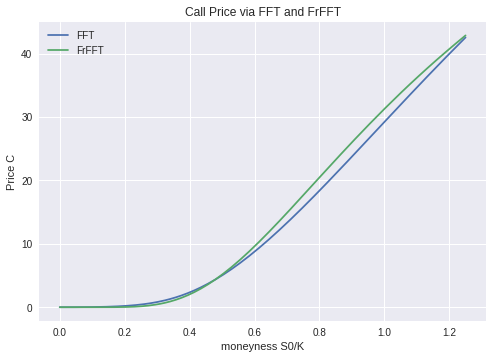

In [0]:
import matplotlib.pyplot as plt
plt.plot(S0/np.exp(km_FFT),cT_km_FFT,label='FFT')
plt.plot(S0/np.exp(km_FrFFT),cT_km_FrFFT,label='FrFFT')
plt.title('Call Price via FFT and FrFFT')
plt.xlabel('moneyness S0/K')
plt.ylabel('Price C')
plt.legend()
plt.show()